In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torch.autograd as autograd
import torchtext.vocab as torchvocab
from torch.autograd import Variable
import numpy as np
import tqdm
import os
import time
import re
import pandas as pd
import string
import gensim
import time
import random
import collections
from collections import Counter
from nltk.corpus import stopwords
from itertools import chain
from sklearn import manifold,metrics
import jieba
#import wandb
#wandb.init(project="attention")

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
def get_wvmodel(mode="word"):
    if mode=="word":
        wvmodel=gensim.models.Word2Vec.load("weibomodel").wv
    else:
        wvmodel=gensim.models.Word2Vec.load("weibo_zh.model").wv
    return wvmodel

In [3]:
traindata=pd.read_csv("./dataset/train.txt",header=None,sep='\t')
traindata.columns=['review','label']
validdata=pd.read_csv("./dataset/dev.txt",header=None,sep='\t')
validdata.columns=['review','label']
testdata=pd.read_csv("./dataset/test.txt",header=None,sep='\t')
testdata.columns=['review','label']

In [4]:
MAX=20


def encode_samples(tokenized_samples):
    features = []
    for sample in tokenized_samples:
        feature = []
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:
                feature.append(0)
        features.append(feature)
    return features

def pad_samples(features, maxlen, PAD=0):
    padded_features = []
    for feature in features:
        if len(feature) >= maxlen:
            padded_feature = feature[:maxlen]
        else:
            padded_feature = feature
            while(len(padded_feature) < maxlen):
                padded_feature.append(PAD)
        padded_features.append(padded_feature)
    return padded_features

def preprocess_data(dataframe):
    data=dataframe.copy()
    data['cut']=data['review'].apply(lambda x:jieba.lcut(x))
    return data[['label','cut']]

def load_data(data,MAX,batch_size,mode="train"):
    x_data=data['cut'].values.tolist()
    y_data=data['label'].values.tolist()
    _features = torch.tensor(pad_samples(encode_samples(x_data),maxlen=MAX))
    _labels = torch.tensor(y_data,dtype=torch.int64)
    _set = torch.utils.data.TensorDataset(_features, _labels)
    if mode=="train":
        _iter = torch.utils.data.DataLoader(_set, batch_size=batch_size,
                                             shuffle=True)
    else:
        _iter = torch.utils.data.DataLoader(_set, batch_size=batch_size,
                                            shuffle=False)
    return _iter

In [6]:
BATCH_SIZE=64
train_data=preprocess_data(traindata)

valid_data=preprocess_data(validdata)

test_data=preprocess_data(testdata)


x_data=pd.concat([train_data.cut,valid_data.cut,test_data.cut])

In [7]:
#词表长度
vocab = set(chain(*x_data))
vocab_size = len(vocab)
print(vocab_size)

23573


In [8]:
#切词长度
len(list(chain(*x_data)))

395306

In [9]:
wvmodel=get_wvmodel()

In [10]:
word_to_idx = {word: i+1 for i, word in enumerate(vocab)}
word_to_idx['<unk>'] = 0
idx_to_word = {i+1: word for i, word in enumerate(vocab)}
idx_to_word[0] = '<unk>'

In [12]:
##如果是字向量，改embed_size
embed_size = 100
weight = torch.zeros(vocab_size+1, embed_size)
for i in range(len(wvmodel.index2word)):
    try:
        index = word_to_idx[wvmodel.index2word[i]]
    except:
        continue
    weight[index, :] = torch.from_numpy(wvmodel.get_vector(
        idx_to_word[word_to_idx[wvmodel.index2word[i]]]))

<ipython-input-12-f738274b59ae>:9: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  weight[index, :] = torch.from_numpy(wvmodel.get_vector(


In [13]:
train_iter=load_data(train_data,MAX,batch_size=BATCH_SIZE,mode="train")
valid_iter=load_data(valid_data,MAX,batch_size=BATCH_SIZE,mode="valid")
test_iter=load_data(test_data,MAX,batch_size=BATCH_SIZE,mode="test")

**here we use self-attention**
$$ U=tanh\left(WX\right)$$
$$ \alpha_{t} = softmax(u_{t}u_{w}) $$
$$ ScoreX=X\alpha $$

In [14]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 bidirectional, weight, labels, use_gpu, **kwargs):
        super(SentimentNet, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.use_gpu = use_gpu
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = True
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
                               num_layers=num_layers, bidirectional=self.bidirectional,
                               dropout=0)
        
        
        if self.bidirectional:
            self.weight_W = nn.Parameter(torch.rand(num_hiddens*2, num_hiddens*2))
            self.weight_proj = nn.Parameter(torch.rand(num_hiddens*2, 1))
        else:
            self.weight_W = nn.Parameter(torch.rand(num_hiddens, num_hiddens))
            self.weight_proj = nn.Parameter(torch.rand(num_hiddens, 1))
            
        self.decoder=nn.Sequential(nn.Linear(num_hiddens*2,num_hiddens),
            nn.Dropout(p=0.5),nn.ReLU(),nn.Linear(num_hiddens,labels))

    def forward(self, inputs):
        embeddings = self.embedding(inputs)

        #embeddings=[batch_size,seq_length,embedded_size]
        states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
        #states=[seq_len, batch, num_directions * hidden_size]
        x=states.permute([1,0,2])
        #x=[batch,seq_len,num_directions*hidden_szie]
        
        #####attention calculation#####
        u = torch.tanh(torch.matmul(x, self.weight_W))
        #u=[batch,seq_len,num_directions*hidden_szie]
        att = torch.matmul(u, self.weight_proj)
        #att=[batch,seq_len,1]
        att_score = F.softmax(att, dim=1)
        #att_score=[batch,seq_len,1],which sum by {seq_len}=1
        scored_x = x * att_score
        #scored_x=[batch,seq_len,num_directions*hidden_szie]
        #####attention_weighted_x
        
        scored_x = torch.sum(scored_x, dim=1)
        #scored_x=[batch,num_directions*hidden_szie]
        outputs=self.decoder(scored_x)
        #outputs=[batch,labels]
        
        return outputs,embeddings,att_score

In [15]:
class textCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len, labels, weight, **kwargs):
        super(textCNN, self).__init__(**kwargs)
        self.labels = labels
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = False
        self.conv1 = nn.Conv2d(1, 1, (2, embed_size))
        self.conv2 = nn.Conv2d(1, 1, (3, embed_size))
        self.conv3 = nn.Conv2d(1, 1, (4, embed_size))
        self.pool1 = nn.MaxPool2d((seq_len - 2 + 1, 1))
        self.pool2 = nn.MaxPool2d((seq_len - 3 + 1, 1))
        self.pool3 = nn.MaxPool2d((seq_len - 4 + 1, 1))
        self.linear = nn.Linear(3, labels)

    def forward(self, inputs):
        inputs = self.embedding(inputs).view(inputs.shape[0], 1, inputs.shape[1], -1)
        x1 = F.relu(self.conv1(inputs))
        x2 = F.relu(self.conv2(inputs))
        x3 = F.relu(self.conv3(inputs))

        x1 = self.pool1(x1)
        x2 = self.pool2(x2)
        x3 = self.pool3(x3)

        x = torch.cat((x1, x2, x3), -1)
        x = x.view(inputs.shape[0], 1, -1)

        x = self.linear(x)
        x = x.view(-1, self.labels)

        return(x)

In [16]:
def category_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.max(preds,1)[1]
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        batch = tuple(t.to(device) for t in batch)
        vectors,labels=batch
        
        optimizer.zero_grad()
        
        predictions,embeddings,att = model(vectors)
        #print(att[0,:,:])
        loss = criterion(predictions, labels)
        
        acc = category_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator),epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            batch = tuple(t.to(device) for t in batch)
            vectors,labels=batch

            predictions,embeddings,att = model(vectors)
            
            loss = criterion(predictions, labels)
            
            acc = category_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

class_list = [x.strip() for x in open( 'dataset/class.txt').readlines()]

def test(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    labels_all = np.array([], dtype=int)
    predicts_all = np.array([], dtype=int)
    
    model.eval()
    with torch.no_grad():

        for batch in iterator:
            batch = tuple(t.to(device) for t in batch)

            vectors,labels=batch

            predictions,embeddings,att = model(vectors)
            
            loss = criterion(predictions, labels)
            
            acc = category_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            labels = labels.data.cpu().numpy()
            predicts = torch.max(predictions, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predicts_all = np.append(predicts_all, predicts)
            
    report = metrics.classification_report(labels_all, predicts_all, target_names=class_list, digits=4)
    confusion = metrics.confusion_matrix(labels_all, predicts_all)
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator),report,confusion
    

In [17]:

num_hiddens = 64
num_layers = 1
labels=7
bidirectional = True
lr = 0.001
device = torch.device('cuda:0')
use_gpu = True
model = SentimentNet(vocab_size=(vocab_size+1), embed_size=embed_size,
                   num_hiddens=num_hiddens, num_layers=num_layers,
                   bidirectional=bidirectional, weight=weight,
                   labels=labels, use_gpu=use_gpu)
model.to(device)
#wandb.watch(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#wandb.watch(model)

In [18]:
N_EPOCHS = 20

best_valid_loss = float('inf')
trainacc,val_acc,trainloss,val_loss=[],[],[],[]

for epoch in range(N_EPOCHS):
    
    start = time.time()
    
    train_loss,train_acc= train(model, train_iter, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, test_iter, criterion)
        
    end = time.time()
        
    runtime = end - start
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-model.pt')
    trainacc.append(train_acc)
    val_acc.append(valid_acc)
    trainloss.append(train_loss)
    val_loss.append(valid_loss)

    #wandb.log({"Test Accuracy": valid_acc, "Test Loss": valid_loss})
    print('epoch: %d, train loss: %.4f, train acc: %.4f, test loss: %.4f, test acc: %.4f, time: %.2f' %
      (epoch, train_loss, train_acc, valid_loss,valid_acc, runtime))

epoch: 0, train loss: 1.6207, train acc: 0.3506, test loss: 1.4282, test acc: 0.4165, time: 2.56
epoch: 1, train loss: 1.2471, train acc: 0.5150, test loss: 1.0588, test acc: 0.5950, time: 1.75
epoch: 2, train loss: 0.7950, train acc: 0.7134, test loss: 0.8926, test acc: 0.6925, time: 1.74
epoch: 3, train loss: 0.4820, train acc: 0.8451, test loss: 0.8811, test acc: 0.7447, time: 1.73
epoch: 4, train loss: 0.3028, train acc: 0.9132, test loss: 0.8967, test acc: 0.7675, time: 1.72
epoch: 5, train loss: 0.2125, train acc: 0.9419, test loss: 0.9801, test acc: 0.7654, time: 1.71
epoch: 6, train loss: 0.1658, train acc: 0.9549, test loss: 1.1540, test acc: 0.7739, time: 1.72
epoch: 7, train loss: 0.1394, train acc: 0.9627, test loss: 1.1418, test acc: 0.7749, time: 1.71
epoch: 8, train loss: 0.1263, train acc: 0.9665, test loss: 1.2473, test acc: 0.7859, time: 1.74
epoch: 9, train loss: 0.1015, train acc: 0.9734, test loss: 1.2951, test acc: 0.7860, time: 1.72
epoch: 10, train loss: 0.0963,

In [19]:
result=test(model,test_iter, criterion)
print("test_acc:  %.4f ,test loss: %.4f"%(result[1],result[0]))
print(result[2])
print(result[3])

test_acc:  0.7907 ,test loss: 1.6989
              precision    recall  f1-score   support

      0 Fear     0.9477    0.9067    0.9267       300
   1 Disgust     0.7348    0.4974    0.5933       195
  2 Optimism     0.8214    0.5935    0.6891       310
  3 Surprise     0.7231    0.9027    0.8030       298
 4 Gratitude     0.9850    0.9887    0.9868       265
   5 Sadness     0.5907    0.8261    0.6888       276
     6 Anger     0.8243    0.7519    0.7864       262

    accuracy                         0.7917      1906
   macro avg     0.8039    0.7810    0.7820      1906
weighted avg     0.8068    0.7917    0.7892      1906

[[272   1   2   8   0  15   2]
 [  2  97   9  30   0  34  23]
 [  4   9 184  29   4  74   6]
 [  4   2   5 269   0  12   6]
 [  0   0   1   0 262   2   0]
 [  5   6  16  16   0 228   5]
 [  0  17   7  20   0  21 197]]


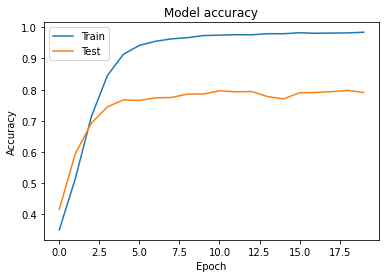

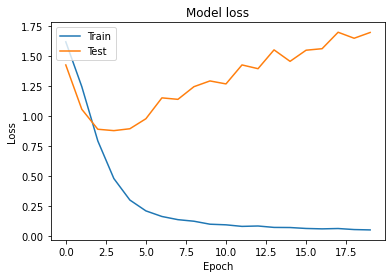

In [20]:
import matplotlib.pyplot as plt
# 绘制训练 
plt.plot(trainacc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(trainloss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
def get_feature(model, iterator,labels):
    model.eval()
    labels=labels
    with torch.no_grad():
        
        origin=torch.zeros([1,MAX*embed_size],dtype=torch.float)
        output=torch.zeros([1,labels],dtype=torch.float)
        label=torch.zeros([1],dtype=torch.int64)
        tmp_origin=origin
        tmp_output=output
        for batch in iterator:
            batch = tuple(t.to(device) for t in batch)
            vectors,label_list=batch
            predictions,embeddings,att = model(vectors)
            embedding=embeddings.view(embeddings.size()[0],embeddings.size()[1]*embeddings.size()[2])
            tmp_output=torch.cat((tmp_output,predictions.cpu().data),0)
            tmp_origin=torch.cat((tmp_origin,embedding.cpu().data),0)
            #print(label_list.size())
            label=torch.cat((label,label_list.cpu().data),0)
    return tmp_origin,tmp_output,label

model.load_state_dict(torch.load('lstm-model.pt'))
begin,end,label=get_feature(model,test_iter,labels)

In [22]:
X=end.numpy()[1:,]

Y=label.numpy()[1:,]

In [23]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)

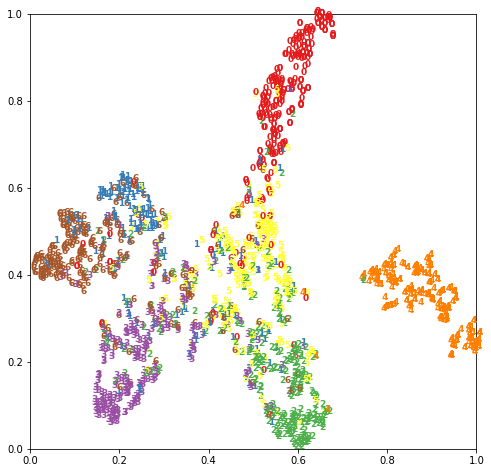

In [24]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(Y[i]), color=plt.cm.Set1(Y[i]), 
             fontdict={'weight': 'bold', 'size': 9})

plt.show()